# ADA - Final project
This notebook aims at giving technical explanations necessary to understand how the results given in the final report were found.

First off, the following commands allow you to retrieve the data necessary to run this notebook locally from the cluster used for this class.
1. Upload the files script.sh and script.py using the following command:  
```bash 
scp -r -p /path/to/script.py GASPAR@iccluster028.iccluster.epfl.ch:/home/GASPAR/script.py  
scp -r -p /path/to/script.sh GASPAR@iccluster028.iccluster.epfl.ch:/home/GASPAR/script.sh
```
2. Connect to the cluster using a second terminal and run the scripts:  
```bash 
ssh GASPAR@iccluster028.iccluster.epfl.ch  
sh script.sh script.py  
```
3. Store the output in the home folder:  
```bash 
hadoop fs -get /user/GASPAR/politics_2016_* file:///home/GASPAR
```
4. Download the data locally using the first terminal:  
```bash 
scp -r GASPAR@iccluster028.iccluster.epfl.ch:/home/GASPAR/politics_2016_* /local/path/to/folder
```

The retrieved dataset consists of several different features listed below:
* **author**: The username of the author of the comment.
* **author_flair_text**: Users can pick so-called *flairs* which are basically tags intended to briefly summarize the user.  They're different for each subreddit, and users can only pick one per subreddit.
* **body**: The content of the comment.
* **created_utc**: The date at which the comment was originally posted.
* **gilded**: Denotes if the comment received a gold. A gold is a form of gratification users can give one another. They're not common because gilding someone costs money.
* **id**: A unique ID that defines the comment.
* **link_id**: A unique ID that determines the post in which the comment was posted to.
* **parent_id**: A unique ID that determines to what the comment is responding to. If it starts with *t1*, the comment is a response to another comment. If it starts with *t3*, the comment is responding directly to the original post.
* **score**: The number of upvotes minus the number of downvotes the comment received.


## Imports

In [62]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer

%matplotlib inline

## Loading data

In [3]:
DATA_PATH = 'data/'

In [4]:
city_states = colors = pd.read_csv(DATA_PATH + 'us_cities_states_counties.csv', delimiter = '|')

In [5]:
politics_06 = pd.read_parquet(DATA_PATH + 'politics_2016_06/')
politics_07 = pd.read_parquet(DATA_PATH + 'politics_2016_07/')
politics_08 = pd.read_parquet(DATA_PATH + 'politics_2016_08/')
politics_09 = pd.read_parquet(DATA_PATH + 'politics_2016_09/')
politics_10 = pd.read_parquet(DATA_PATH + 'politics_2016_10/')
politics_11 = pd.read_parquet(DATA_PATH + 'politics_2016_11/')

## Cleaning data

Features are converted into appropriate format.  
Redundant data are removed as well.  
  
It is possible to retrieve if the comment was responding to a post or to another comment by matching *link_id* and *parent_id*.

In [6]:
# created_utc is converted to the datetime format
politics_06['created_utc'] = pd.to_datetime(politics_06['created_utc'], unit='s')
politics_07['created_utc'] = pd.to_datetime(politics_07['created_utc'], unit='s')
politics_08['created_utc'] = pd.to_datetime(politics_08['created_utc'], unit='s')
politics_09['created_utc'] = pd.to_datetime(politics_09['created_utc'], unit='s')
politics_10['created_utc'] = pd.to_datetime(politics_10['created_utc'], unit='s')
politics_11['created_utc'] = pd.to_datetime(politics_11['created_utc'], unit='s')

# author_flair_text is converted to a category
politics_06['author_flair_text'] = politics_06['author_flair_text'].astype('category')
politics_07['author_flair_text'] = politics_07['author_flair_text'].astype('category')
politics_08['author_flair_text'] = politics_08['author_flair_text'].astype('category')
politics_09['author_flair_text'] = politics_09['author_flair_text'].astype('category')
politics_10['author_flair_text'] = politics_10['author_flair_text'].astype('category')
politics_11['author_flair_text'] = politics_11['author_flair_text'].astype('category')

# remove unnecessary information in link_id and parent_id
politics_06['link_id'] = politics_06['link_id'].str.slice(3)
politics_07['link_id'] = politics_07['link_id'].str.slice(3)
politics_08['link_id'] = politics_08['link_id'].str.slice(3)
politics_09['link_id'] = politics_09['link_id'].str.slice(3)
politics_10['link_id'] = politics_10['link_id'].str.slice(3)
politics_11['link_id'] = politics_11['link_id'].str.slice(3)
politics_06['parent_id'] = politics_06['parent_id'].str.slice(3)
politics_07['parent_id'] = politics_07['parent_id'].str.slice(3)
politics_08['parent_id'] = politics_08['parent_id'].str.slice(3)
politics_09['parent_id'] = politics_09['parent_id'].str.slice(3)
politics_10['parent_id'] = politics_10['parent_id'].str.slice(3)
politics_11['parent_id'] = politics_11['parent_id'].str.slice(3)


In [7]:
politics_06.head()

,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score
0,wheresthecheese,NaN,I'm very glad I read that. The first well thou...,2016-06-01 00:00:00,0,d3r38dt,4lxbri,4lxbri,3
1,ifCreepyImJoking,NaN,"Eh, once you start adding qualifiers instead o...",2016-06-01 00:00:03,0,d3r38gd,4lwef1,d3r17zv,0
2,Sam_Munhi,NaN,How so? Clinton and Trump are the two most dis...,2016-06-01 00:00:12,0,d3r38n2,4lxbzg,d3r0tm6,4
3,VowOfKsitigarbha,NaN,Is he attacking the wrong target?,2016-06-01 00:00:12,0,d3r38n4,4lycd3,4lycd3,25
4,iAMADisposableAcc,NaN,"We can agree on that, although I guess we have...",2016-06-01 00:00:15,0,d3r38q3,4lw22m,d3r2rv0,2


Dataframes for each month are then concatenated into one massive Dataframe whose data types are just as expected.

In [8]:
politics = pd.concat([politics_06, politics_07, politics_08, politics_09, politics_10, politics_11]).reset_index()
politics['author_flair_text'] = politics['author_flair_text'].astype('category') #necessary to do it again

In [9]:
politics.dtypes

index                         int64
author                       object
author_flair_text          category
body                         object
created_utc          datetime64[ns]
gilded                        int64
id                           object
link_id                      object
parent_id                    object
score                         int64
dtype: object

In [10]:
politics.describe()

,index,gilded,score
count,1.086033e+07,1.086033e+07,1.086033e+07
mean,9.539365e+05,3.835981e-04,6.766324e+00
std,6.041415e+05,2.441999e-02,5.706394e+01
min,0.000000e+00,0.000000e+00,-8.620000e+02
25%,4.525130e+05,0.000000e+00,1.000000e+00
50%,9.050270e+05,0.000000e+00,1.000000e+00
75%,1.370547e+06,0.000000e+00,4.000000e+00
max,2.522909e+06,1.400000e+01,1.901100e+04


In [11]:
politics.head()

,index,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score
0,0,wheresthecheese,NaN,I'm very glad I read that. The first well thou...,2016-06-01 00:00:00,0,d3r38dt,4lxbri,4lxbri,3
1,1,ifCreepyImJoking,NaN,"Eh, once you start adding qualifiers instead o...",2016-06-01 00:00:03,0,d3r38gd,4lwef1,d3r17zv,0
2,2,Sam_Munhi,NaN,How so? Clinton and Trump are the two most dis...,2016-06-01 00:00:12,0,d3r38n2,4lxbzg,d3r0tm6,4
3,3,VowOfKsitigarbha,NaN,Is he attacking the wrong target?,2016-06-01 00:00:12,0,d3r38n4,4lycd3,4lycd3,25
4,4,iAMADisposableAcc,NaN,"We can agree on that, although I guess we have...",2016-06-01 00:00:15,0,d3r38q3,4lw22m,d3r2rv0,2


In [56]:
print(set(politics['author_flair_text'].dropna()))
print(len(set(politics['author_flair_text'].dropna())))

{'Alaska', 'Nicholas Schou, author of "Spooked"', 'Zephyr Teachout (D-NY)', 'Minnesota', 'America’s favorite democracy holiday', 'Wisconsin', 'Eddie Goldberg, author of "Joint Ventured Nation"', 'I voted', 'Montana', 'Maria Teresa Kumar, CEO of Voto Latino', 'Arizona', 'Puerto Rico', 'NORML', 'American Civil Liberties Union', 'Florida', 'Retain A Just Nebraska', 'Nevada', 'Utah', 'California | the AMA guy', 'Chad Marlow, Advocacy and Policy Counsel at ACLU', 'West Virginia', 'Idaho', 'New York', 'Dan Rolle (D-NV)', 'Oklahoma', 'Republic of Popcornia', 'Sara Tabatabaie, Digital Manager of Rock The Vote', 'Steve Gladstone', 'Matt Mitchell, founder of CryptoHarlem', 'Illinois', 'Tennessee', 'District Of Colombia', 'American Samoa', 'Jesse Ventura (I-MN)', 'No on 66', 'Mainers for Fair Wages', 'Commissioner Walter Deleon (DC)', 'Sr. Economic Analyst', 'Keep Colorado Working', 'Eliot Nelson, Huffington Post political reporter', 'Kentucky', 'Michigan', 'Texas', 'Scott Wiener (D-CA)', 'New Me

In [50]:
state_full = set(np.array(city_states['State_full'].dropna()))
print(state_full)
print(len(state_full))

{'Alaska', 'Maine', 'Wyoming', 'Kentucky', 'Michigan', 'North Carolina', 'Wisconsin', 'Minnesota', 'Delaware', 'South Carolina', 'Alabama', 'Montana', 'Northern Mariana Islands', 'US Armed Forces Europe', 'Arizona', 'Puerto Rico', 'Texas', 'New Mexico', 'Vermont', 'Florida', 'New Jersey', 'Nebraska', 'Nevada', 'Utah', 'Missouri', 'Arkansas', 'Hawaii', 'New Hampshire', 'Iowa', 'Federated States of Micronesia', 'West Virginia', 'Ohio', 'Idaho', 'Pennsylvania', 'New York', 'South Dakota', 'US Armed Forces Pacific', 'Oklahoma', 'Indiana', 'Colorado', 'California', 'Washington, D.C.', 'Guam', 'Oregon', 'Illinois', 'Virgin Islands', 'Rhode Island', 'Washington', 'Palau', 'Mississippi', 'Marshall Islands', 'Tennessee', 'Massachusetts', 'American Samoa', 'North Dakota', 'Maryland', 'Louisiana', 'Virginia', 'Georgia', 'Connecticut', 'Kansas'}
61


In [52]:
flair_politics = politics[politics['author_flair_text'].isin(state_full)]
print(set(flair_politics['author_flair_text']))
len(set(flair_politics['author_flair_text']))

{'Alaska', 'Maine', 'Wyoming', 'Kentucky', 'Michigan', 'North Carolina', 'Minnesota', 'Wisconsin', 'Alabama', 'South Carolina', 'Delaware', 'Montana', 'Arizona', 'Puerto Rico', 'Texas', 'New Mexico', 'Vermont', 'Florida', 'New Jersey', 'Nevada', 'Nebraska', 'Utah', 'Missouri', 'Arkansas', 'Hawaii', 'Iowa', 'New Hampshire', 'West Virginia', 'Ohio', 'Idaho', 'Pennsylvania', 'New York', 'South Dakota', 'Oklahoma', 'Indiana', 'Colorado', 'California', 'Oregon', 'Guam', 'Illinois', 'Washington', 'Rhode Island', 'Mississippi', 'Tennessee', 'Massachusetts', 'American Samoa', 'North Dakota', 'Maryland', 'Louisiana', 'Virginia', 'Georgia', 'Connecticut', 'Kansas'}


53

In [54]:
print(flair_politics.shape)
flair_politics.head()

(215850, 10)


,index,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score
6147305,1669459,Qu1nlan,California,Hi `juno255`. Thank you for participating in /...,2016-09-30 02:31:46,0,d87sxgv,5552n9,5552n9,1
6147372,1669526,Qu1nlan,California,Hi `Alejandro_Last_Name`. Thank you for partic...,2016-09-30 02:33:36,0,d87t05c,5556yb,5556yb,1
6147390,1669544,Qu1nlan,California,Hi `ImNotJesus`. Thank you for participating i...,2016-09-30 02:33:57,0,d87t0p2,5548v7,5548v7,1
6147458,1669612,Qu1nlan,California,Hi `cmonshoe`. Thank you for participating in ...,2016-09-30 02:35:17,0,d87t2mq,5541x2,5541x2,1
6147507,1669661,Qu1nlan,California,Hi `abourne`. Thank you for participating in /...,2016-09-30 02:36:23,0,d87t4ep,554okj,554okj,1


## Processing data

In [63]:
def nlp_entity(body):
    """Creates a string with each named entity preceded by its corresponding tag and separated with a comma"""
    entities = ''
    for sent in nltk.sent_tokenize(body):
        for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
            if hasattr(chunk, 'label'):
                 entities += (chunk.label() + ' ' + ' '.join(c[0] for c in chunk) + ',' )
    return entities[:-1]
                
def nlp_sentiment(body, sid=SentimentIntensityAnalyzer()):
    """Creates a string containing 4 numeric values corresponding to a sentiment analysis
    oredered as such compound, neg, neu, pos separated by a comma."""
    ss = sid.polarity_scores(body)
    sentiment = ""
    for k in sorted(ss):
        sentiment += '{},'.format(ss[k])
    return sentiment[:-1]

def nlp_wordcount(body, lemmatizer=nltk.WordNetLemmatizer(), stops=set(nltk.corpus.stopwords.words("english"))):
    """Returns a dictionnary with words frequency easily plottable."""
    fdist = nltk.FreqDist()
    tokens = nltk.word_tokenize(body)
    filtered_words = [word for word in tokens if word not in stops]
    for word in filtered_words:
        fdist[lemmatizer.lemmatize(word.lower())] += 1      
    return fdist

def sentiment_to_label(sentiment):
    ss = sentiment.split(',')
    compound = float(ss[0])
    if (compound > 0.2):
        return "Positive"
    elif (compound < -0.2):
        return "Negative"
    else:
        return "Neutral"

In [64]:
sample = politics.sample(10).copy()

sample['entity'] = sample['body'].apply(nlp_entity)
sample['sentiment'] = sample['body'].apply(nlp_sentiment)
sample['wordcount'] = sample['body'].apply(nlp_wordcount)
sample['label'] = sample['sentiment'].apply(sentiment_to_label)
sample

,index,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score,entity,sentiment,wordcount,label
1464930,172425,Rottendog,NaN,I don't care what anyone says; Jeb never wante...,2016-07-05 20:18:06,0,d50gfki,4rd7ly,d507n4m,9,"PERSON Jeb,ORGANIZATION NOPE,GPE Aww","-0.1847,0.112,0.804,0.084","{'i': 5, 'n't': 1, 'care': 1, 'anyone': 1, 'sa...",Neutral
3327733,249575,BalanceCoil,NaN,Duh a link to the article or page it was inclu...,2016-08-04 20:29:10,0,d64f9je,4w6kr2,d64f4u8,0,,"0.0,0.0,1.0,0.0","{'duh': 1, 'link': 1, 'article': 1, 'page': 1,...",Neutral
6117050,1639204,Satyrsol,NaN,"Thinking just this election cycle, I'll use Be...",2016-09-29 16:40:40,0,d8734va,55200c,d8725pi,1,"PERSON Bernie Sanders,PERSON Bernie Sanders,PE...","0.2535,0.053,0.89,0.057","{'thinking': 1, 'election': 1, 'cycle': 1, ','...",Positive
5417390,939544,ricdesi,NaN,Bulllllllllllllllshit.,2016-09-19 13:49:31,0,d7t3vv3,53btku,53btku,1,GPE Bulllllllllllllllshit,"0.0,0.0,1.0,0.0","{'bulllllllllllllllshit': 1, '.': 1}",Neutral
3896448,818290,justjack48,NaN,More tax dollars going to waste on another poi...,2016-08-16 23:39:58,0,d6kf9o5,4y2kke,4y2kke,10,,"-0.4215,0.219,0.781,0.0","{'more': 1, 'tax': 1, 'dollar': 1, 'going': 1,...",Negative
7806334,1609258,ClassicsMajor,NaN,He's overcompensating.\n,2016-10-23 05:43:54,0,d93yfg1,58wq86,d93w5mj,4,,"0.0,0.0,1.0,0.0","{'he': 1, ''s': 1, 'overcompensating': 1, '.': 1}",Neutral
5820352,1342506,Sussay,NaN,"I assure you. I work with data all the time, a...",2016-09-26 15:10:47,0,d82pi3k,54kz3q,d82pfhf,-4,,"0.34,0.0,0.893,0.107","{'i': 3, 'assure': 1, '.': 3, 'work': 1, 'data...",Positive
422932,422932,Brunopolis,NaN,16% variance in the California Democratic prim...,2016-06-08 22:58:50,0,d41keni,4n7v7t,4n7v7t,1,"ORGANIZATION California Democratic,GPE California","0.0,0.0,1.0,0.0","{'16': 1, '%': 2, 'variance': 2, 'california':...",Neutral
6201221,4145,Idolglows,NaN,"The worst possible thing on EARTH, to you, is ...",2016-10-01 02:03:46,0,d8941jc,55atwx,d89399c,1,"ORGANIZATION EARTH,PERSON Sorry","-0.2894,0.159,0.683,0.158","{'the': 1, 'worst': 1, 'possible': 1, 'thing':...",Negative
3250908,172750,hotpotamus,NaN,I'm an engineer. I might be upper middle class...,2016-08-03 17:14:41,0,d62ph32,4vzbki,d62pd2q,7,,"0.8271,0.0,0.765,0.235","{'i': 5, ''m': 1, 'engineer': 1, '.': 3, 'migh...",Positive


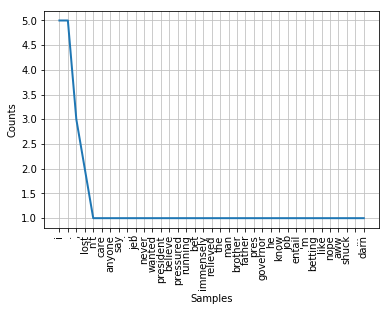

In [65]:
sample.iloc[0]['wordcount'].plot()

### Words positive or negative
Using flair only dataset

In [23]:
def get_word_count(df, sentiment):
    """ Get the word count according to the sentiment. Can be 'Positive', 'Negative', 'Neutral' or 'None' """
    if sentiment != 'None':
        filtered_df = df[df['label'] == sentiment]
    else:
        filtered_df = df.copy()
    fdists = list(filtered_df['wordcount'])
    tot_fd = nltk.FreqDist()
    for fdist in fdists:
        for key in fdist:
            tot_fd[key] += fdist.get(key)
            
    return tot_fd

sorted_score = flair_city_politics.sort_values(by=['score'], ascending=False)

#### Taking good scores into account

In [24]:
good_score = sorted_score[sorted_score['score'] > 1000].copy()

good_score['entity'] = good_score['body'].apply(nlp_entity)
good_score['sentiment'] = good_score['body'].apply(nlp_sentiment)
good_score['wordcount'] = good_score['body'].apply(nlp_wordcount)
good_score['label'] = good_score['sentiment'].apply(sentiment_to_label)
good_score.head()

,index,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score,entity,sentiment,wordcount,label
10003704,1666288,PoliticsBTFO,Texas,Bernie is in the title. This will get 5000 upv...,2016-11-17 15:11:14,3,da491ew,5dfjg3,da47ua7,8351,"PERSON Bernie,PERSON Trumps,PERSON Pentagon,PE...","-0.3786,0.113,0.782,0.105","{'bernie': 3, 'title': 1, '.': 8, 'this': 2, '...",Negative
7091994,894918,ellouelle,California,&gt;here come the rape police\n\nActual police...,2016-10-13 11:32:27,1,d8q3twj,579rh0,d8q3t61,6420,,"-0.6908,0.299,0.701,0.0","{'&': 1, 'gt': 1, ';': 1, 'come': 2, 'rape': 1...",Negative
10648484,2311068,lipsyncforyourlife,Florida,So the guy is saying there are a ton of illega...,2016-11-27 21:13:46,0,dai1myk,5f7jw2,5f7jw2,6084,,"-0.7622,0.213,0.787,0.0","{'so': 1, 'guy': 2, 'saying': 1, 'ton': 1, 'il...",Negative
10097818,1760402,ShroudedSciuridae,America,There you go taking him out of context again b...,2016-11-18 18:50:41,1,da5zrun,5dnzjx,da5zger,5573,,"0.0,0.0,1.0,0.0","{'there': 1, 'go': 1, 'taking': 1, 'context': ...",Neutral
6996195,799119,anon902503,Wisconsin,"DON'T LISTEN TO THE LIBERAL ""FACT"" POLICE. CA...",2016-10-12 02:37:03,1,d8o9mca,571wsx,571wsx,5165,"ORGANIZATION LIBERAL,ORGANIZATION YOUR,ORGANIZ...","0.4995,0.0,0.823,0.177","{'do': 1, 'n't': 1, 'listen': 1, 'to': 1, 'the...",Positive


In [25]:
word_positive_good = get_word_count(good_score, 'Positive')
word_negative_good = get_word_count(good_score, 'Negative')
word_count_good = get_word_count(good_score, 'None')

In [26]:
word_positive_good.most_common(10)

[('.', 320),
 (',', 226),
 (':', 97),
 ('trump', 67),
 (';', 67),
 ('&', 63),
 ("'s", 63),
 ('i', 60),
 ('(', 51),
 (')', 51)]

In [27]:
word_negative_good.most_common(10)

[('.', 328),
 (',', 204),
 ('i', 78),
 ("'s", 60),
 ('trump', 52),
 ("n't", 52),
 (':', 45),
 (';', 35),
 ("''", 28),
 ('&', 28)]

In [28]:
word_count_good.most_common(10)

[('.', 748),
 (',', 504),
 (':', 161),
 ('i', 158),
 ('trump', 148),
 ("'s", 140),
 (';', 110),
 ('&', 99),
 ("n't", 96),
 ("''", 86)]

#### Bad scores

In [29]:
bad_score = sorted_score[sorted_score['score'] < 0].copy()

bad_score['entity'] = bad_score['body'].apply(nlp_entity)
bad_score['sentiment'] = bad_score['body'].apply(nlp_sentiment)
bad_score['wordcount'] = bad_score['body'].apply(nlp_wordcount)
bad_score['label'] = bad_score['sentiment'].apply(sentiment_to_label)
bad_score.head()

,index,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score,entity,sentiment,wordcount,label
6353744,156668,sicilianthemusical,Arizona,Patently untrue. A lie. A fabrication. A false...,2016-10-04 01:39:04,0,d8cyspp,55qt0c,d8cxs4n,-1,PERSON Clinton,"-0.2732,0.14,0.768,0.092","{'patently': 1, 'untrue': 1, '.': 6, 'a': 3, '...",Negative
7826283,1629207,FookYu315,New York,The media gave Bernie far less coverage. The D...,2016-10-23 18:49:32,0,d94ji3y,58lchd,d94hn16,-1,"PERSON Bernie,ORGANIZATION DNC,ORGANIZATION DN...","-0.1531,0.088,0.805,0.108","{'the': 4, 'medium': 1, 'gave': 1, 'bernie': 2...",Neutral
6348160,151084,CNegan,Texas,"Bold strategy, Cotton.",2016-10-03 23:33:07,0,d8ctnr1,55qn00,55qn00,-1,"GPE Bold,GPE Cotton","0.3818,0.0,0.435,0.565","{'bold': 1, 'strategy': 1, ',': 1, 'cotton': 1...",Positive
8082629,1885553,VintageSin,Virginia,Really now... So primaries only exist for gene...,2016-10-28 09:31:10,0,d9b7rh2,59r63s,d9b5r28,-1,,"0.5149,0.073,0.797,0.13","{'really': 1, '...': 3, 'so': 1, 'primary': 2,...",Positive
7971795,1774719,IOnlyKnow5Words,New Jersey,What the fuck did you say about me you fucking...,2016-10-26 14:17:51,0,d98hwac,59fp77,d98fz3b,-1,"PERSON Hillary,PERSON Trump,PERSON Stein,PERSO...","0.7424,0.169,0.603,0.228","{'what': 1, 'fuck': 1, 'say': 1, 'fucking': 1,...",Positive


In [30]:
word_positive_bad = get_word_count(bad_score, 'Positive')
word_negative_bad = get_word_count(bad_score, 'Negative')
word_count_bad = get_word_count(bad_score, 'None')

In [31]:
word_positive_bad.most_common(10)

[('.', 11632),
 (',', 6999),
 ('i', 3072),
 ("'s", 2590),
 ("n't", 2274),
 ('?', 1849),
 ('trump', 1310),
 ('like', 1093),
 (';', 1020),
 (':', 961)]

In [32]:
word_negative_bad.most_common(10)

[('.', 12885),
 (',', 7565),
 ('i', 3036),
 ("'s", 2902),
 ("n't", 2636),
 ('?', 2347),
 ('trump', 1543),
 ('people', 1201),
 (';', 1068),
 ('&', 998)]

In [33]:
word_count_bad.most_common(10)

[('.', 29585),
 (',', 16858),
 ('i', 7328),
 ("'s", 6628),
 ("n't", 6003),
 ('?', 5397),
 ('trump', 3423),
 ('people', 2487),
 (';', 2438),
 (':', 2288)]

#### Compare good and bad
Which one are in both sets?

In [34]:
both = []
good_only = nltk.FreqDist()
for good in word_count_good:
    if good in word_count_bad:
        both.append(good)
    else:
        good_only[good] = word_count_good.get(good)

In [35]:
both[:10]

['bernie', 'title', '.', 'this', 'get', 'upvotes', 'next', '2', 'hour', 'easy']

In [36]:
good_only.most_common(10)

[('**endorsed', 14),
 ('***the', 12),
 ('non-republican', 4),
 ('johnson**', 4),
 ('inc.', 3),
 ('mkc', 3),
 ('directv', 3),
 ('//scholar.google.com/scholar_case', 3),
 ('hl=en', 3),
 ('as_sdt=2006', 3)]

In [37]:
bad_only = nltk.FreqDist()
for bad in word_count_bad:
    if bad not in word_count_good:
        bad_only[bad] = word_count_bad.get(bad)

In [38]:
bad_only.most_common(10)

[('maybe', 340),
 ('russian', 315),
 ('russia', 309),
 ('system', 261),
 ('different', 214),
 ('argument', 213),
 ('politician', 207),
 ('fbi', 182),
 ('love', 176),
 ('did', 162)]

## Visualizing data

To get a feel for the dataset, a histogram with the number of comments for each day is plotted.

In [39]:
# computation of the number of days the dataset spans
days = (politics.iloc[-1].created_utc - politics.iloc[0].created_utc).days + 1

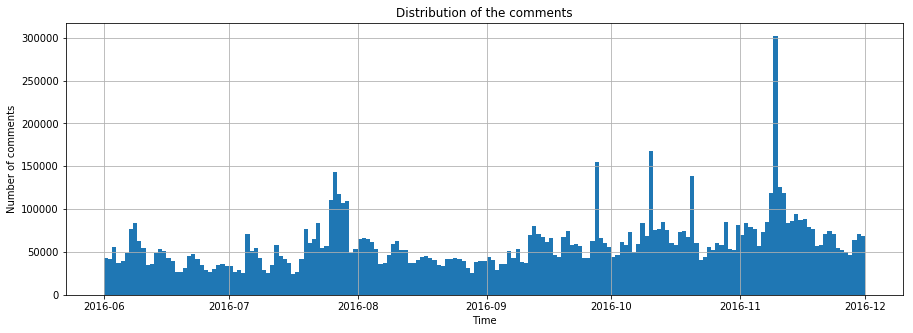

In [40]:
plt.figure(figsize=(15,5))
plt.grid()
plt.hist(politics['created_utc'], bins=days)
plt.ylabel('Number of comments')
plt.xlabel('Time')
plt.title('Distribution of the comments')
plt.show()